# LOADING DATA 


## Data Preparation & Exploration

In [2]:
"""Data Preparation & Exploration

Here we will prepare the data for the predictions. We are interested in only those columns of s0 matrix which reference target data (not class data) and only those rows which correspond to inchikeys which have standarisable smiles. 

We are also interested in exploring the amount of positive compounds we have for a given target.

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Prepare Data
    4. Save Data
    5. Data Exploration
"""

# 1. Imports, Variables, Functions
# imports
import h5py, numpy as np, pandas as pd, sys, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
from tqdm.contrib.concurrent import process_map
from tqdm import tqdm
import pickle

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")
# variables
b4_s4_data_path = os.path.join(
    "/aloy/", "web_checker", "current", "full", "B", "B4", "B4.001", "sign4", "sign4.h5"
)

b4_s0_data_path = os.path.join(
    "/aloy/", "web_checker", "current", "full", "B", "B4", "B4.001", "sign0", "sign0.h5"
)

cc_smiles_path = os.path.join(
    "/aloy/",
    "home",
    "acomajuncosa",
    "Aksel",
    "CC_standardisation_standardiser",
    "CC_MOLECULES_STD.tsv",
)
data_output_path = os.path.join("..", "data", "B4.001", "s0_filtered.h5")


inchikey_failed_mapc = [
    "FOLRZVDNLGHIOC-DMXXOQFQSA-L",
    "ICPUWTORQSFCPE-BHVUHMJOSA-L",
    "JGQCYTLLVMXXQL-LGRLCBGBSA-N",
    "KBPQVWUBVGLKRQ-LNHPXXNLSA-L",
    "RXJKYBQTPDFIPO-PWSFYNAUSA-L",
    "UXJXOYOZCMIBIG-MYESYUTFSA-N",
    "WUCVZNCZYXRPHR-LTBQDQKYSA-N",
]

smile_failed_mapc = [
    "C[N+]1(C)C[C@@]23c4c5c6c7c8c9c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c%21c(c2c2c4c4c6c9c6c4c4c2c%21c2c%19c(c%18%14)c9c%13c%10c6c9c24)C2=C4c6c(c-%16c9c%10c6[C@H]([C@@H]5C7=C%10[C@]5(C[N+](C)(C)C[C@]8%115)[C@H]9[C@H]%15%12)[C@@]43C1)[C@@H]%17[C@H]2%20",
    "CCCCCCCCCC[N@+]1(C)C[C@@]23c4c5c6c7c8c9c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c%21c(c2c2c4c4c6c9c6c4c4c2c%21c2c%19c(c%18%14)c9c%13c%10c6c9c24)C2=C4c6c(c-%16c9c%10c6[C@H]([C@@H]5C7=C%10[C@]5(C[N+](C)(C)C[C@]8%115)[C@H]9[C@H]%15%12)[C@@]43C1)[C@@H]%17[C@H]2%20",
    "O=C(O)CN1C[C@@]23C4=C5c6c7c8c9c(c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c%21c%22c%23c(c6c6c8c8c%24c9c%11c9c(c%16%12)c%17c%11c%19c%12c%21c%23c6c8c%12c%11c9%24)[C@@H]5[C@@H]5C=%22[C@H]6c8c5c4c(c-%14c8[C@H]%15[C@@H]%18[C@@H]%206)[C@@H]2[C@H]%13%10)[C@]73[C@@H]1C(=O)O",
    "C[N+]1(C)C[C@@]23C4=C5C6=C7[C@@H]8C9=c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c%21c%22c%23c(c4c4c2c2c%24c%25c(c%10c(c%11%15)c%10c%16c%19c(c%25%10)c%10c%20c%23c4c%24%10)[C@@H]2[C@H]9[C@]73C1)[C@H]1C%22=C2c3c(c6c(c-%13c3[C@H]([C@H]%14%17)[C@@]23C[N+](C)(C)C[C@]%21%183)[C@@H]%128)[C@@H]51",
    "C[N+]1(C)C[C@]23c4c5c6c7c8c9c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c(c2c2c4c4c6c6c8c%10c8c%12c%10c%14c(c%15%19)c%12c%20c2c2c4c6c8c%10c%122)[C@@H]%18[C@H]2c4c6c8c%10c(c4-%17)[C@@H]%16[C@H]%13[C@@]%114C[N+](C)(C)C[C@]%104C=9[C@H]8[C@@H]7C5=C6[C@]23C1",
    "O=C(O)C1(C(=O)O)[C@@]23C4=c5c6c7c8c9c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c%21c%22c%23c(c5c5c6c6c8c%11c8c%11c%12c%15c%12c(c%20%16)c%21c%15c%23c5c(c68)c%15c%12%11)[C@@]12[C@@H]%22[C@H]%19c1c-%18c2c5c(c13)[C@@H]4[C@@H]7C9=C5[C@@]1([C@H]2[C@H]%17%14)C(C(=O)O)(C(=O)O)[C@]%10%131",
    "C=C(O)C[C@H]1[C@@H](C(=O)O)[C@@]23C4=C5c6c7c8c9c(c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c%21c%22c%23c(c6c6c8c8c%24c9c%11c9c(c%16%12)c%17c%11c%19c%12c%21c%23c6c8c%12c%11c9%24)[C@@H]5[C@@H]5C=%22[C@H]6c8c5c4c(c-%14c8[C@H]%15[C@@H]%18[C@@H]%206)[C@@H]2[C@H]%13%10)[C@]73[C@@H]1C(=O)O",
]


# functions
def check_membership(ik, reference_set):
    """Check Membership
    Arguments:
        - ik (str): inchikey
        - reference_set (set): set of inchikeys
    Returns:
        - bool: whether the inchikey is in the reference set
    """
    return ik in reference_set


# 2. Load Data
if not os.path.exists(data_output_path):

    pass
    # load signature 0 data
    with h5py.File(b4_s0_data_path, "r") as f:
        print(f.keys())
        s0_features = f["features"][:].astype("<U")
        s0_iks = f["keys"][:].astype("<U")
        s0_V = f["V"][:]

    logging.info(f"Shape of s0_V: {s0_V.shape}")

    # load signature 0 smiles
    df_cc_smiles = pd.read_csv(cc_smiles_path, sep="\t")

    # 3. Prepare Data
    # Convert inchikeys to a set for faster membership testing
    inchikey_set = set(df_cc_smiles["inchikey"].values)

    # check which inchikeys have standrised smiles
    # this will be our row mask
    rows_mask_1 = process_map(
        check_membership,
        s0_iks,
        [inchikey_set] * len(s0_iks),
        max_workers=200,
        chunksize=1000,
    )

    # mask out inchikeys which failed to be converted
    # int this case to MAPC
    inchikey_failed_mapc_set = set(inchikey_failed_mapc)

    rows_mask_2 = process_map(
        check_membership,
        s0_iks,
        [inchikey_failed_mapc_set] * len(s0_iks),
        max_workers=200,
        chunksize=1000,
    )

    # mask out inchikeys which failed to be converted
    # into this case UNIMOL
    with open(
        os.path.join("../", "data", "B4.001", "iks_failed_unimol.pkl"),
        "rb",
    ) as f:
        iks_failed_unimol = pickle.load(f)

    logging.info(f"Failed inchikeys {len(iks_failed_unimol)}")

    rows_mask_3 = process_map(
        check_membership,
        s0_iks,
        [iks_failed_unimol] * len(s0_iks),
        max_workers=200,
        chunksize=1000,
    )

    # Convert result to a numpy array
    rows_mask_1 = np.array(rows_mask_1)

    # INVERT this mask because we do NOT want to keep these compouds
    rows_mask_2 = ~np.array(rows_mask_2)
    rows_mask_3 = ~np.array(rows_mask_3)
    logging.info(f"Failed inchikeys MAPC {np.sum(~rows_mask_2)}")
    logging.info(f"Failed inchikeys UNIMOL {np.sum(~rows_mask_3)}")

    # rows_mask = np.logical_and(rows_mask_1, rows_mask_2)

    rows_mask = rows_mask_1 & rows_mask_2 & rows_mask_3

    # check if these

    logging.info(
        f"Found {sum(rows_mask)} / {len(rows_mask)} inchikeys in the CC dataset"
    )
    # masked iks
    s0_iks_masked = s0_iks[rows_mask]

    # for active compounds, they can have 1 or 2 as values
    # consider both as active class
    s0_V = np.where(s0_V > 0, 1, s0_V)

    # mask columns which do not belong to protein target but rather to class data
    column_mask = np.array(
        [False if c.startswith("Class:") else True for c in s0_features]
    )
    s0_features_masked = s0_features[column_mask]
    logging.info(
        "Number of columns after masking: %d out of %d",
        np.sum(column_mask),
        len(column_mask),
    )

    # row and column mask
    # here we will filter out inchikeys which have not got standirsable smiles
    # and columns which do not correspond to target data
    s0_V_masked = s0_V[rows_mask, :][:, column_mask]

    logging.info(f"Shape of s0_V_masked: {s0_V_masked.shape}")

    # count the number of actives for each target
    n_actives_per_target = np.sum(s0_V_masked, axis=0)
    column_filter = np.where(n_actives_per_target >= 5, True, False)

    logging.info(
        f"Number of targets with at least 5 actives: {np.sum(column_filter)} / {len(column_filter)}"
    )

    # count the number of actives for each target
    n_actives_per_target = np.sum(s0_V_masked, axis=0)

    # remove columns with less than 5 actives
    s0_V_filtered = s0_V_masked[:, column_filter]

    # filtered features
    s0_features_filtered = s0_features_masked[column_filter]

    logging.info(f"Shape of s0_V_filtered: {s0_V_filtered.shape}")
    # create a dictionary of inchikey to smiles
    # Search time for dictionary is linear O(n)
    ik_2_smile = dict(zip(df_cc_smiles["inchikey"], df_cc_smiles["smiles"]))

    # get s0 standarised smiles
    s0_smiles = list()
    for s0_ik in tqdm(s0_iks_masked):
        s0_smiles.append(ik_2_smile[s0_ik])

    # Convert the string data to a numpy array with dtype 'S' for ASCII or 'U' for Unicode
    s0_features_filtered = np.array(s0_features_filtered, dtype="S")
    s0_smiles = np.array(s0_smiles, dtype="S")
    s0_iks_masked = np.array(s0_iks_masked, dtype="S")

    logging.info(
        f"Data to be saved V: {s0_V_filtered.shape}, features: {s0_features_filtered.shape}, smiles: {len(s0_smiles)}, inchikeys: {len(s0_iks_masked)}"
    )

    # 4. Save Data
    with h5py.File(data_output_path, "w") as f:
        f.create_dataset("V", data=s0_V_filtered)
        f.create_dataset("features", data=s0_features_filtered)
        f.create_dataset("smiles", data=s0_smiles)
        f.create_dataset("inchikeys", data=s0_iks_masked)

else:
    # load data from the saved file
    with h5py.File(data_output_path, "r") as f:
        s0_V_filtered = f["V"][:]
        s0_features_filtered = f["features"][:].astype(str)
        s0_smiles = f["smiles"][:].astype(str)
        s0_iks_masked = f["inchikeys"][:].astype(str)

    logging.info(
        f"Data loaded V: {s0_V_filtered.shape}, features: {s0_features_filtered.shape}, smiles: {len(s0_smiles)}, inchikeys: {len(s0_iks_masked)}"
    )

/home/ddalton/miniconda3/envs/UniCore-env/lib/python3.10/site-packages/tqdm-4.66.4-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
logging.info(f"Failed inchikeys {np.sum(rows_mask_3)}")

2024-05-27 21:02:49,107 - Failed inchikeys 628992


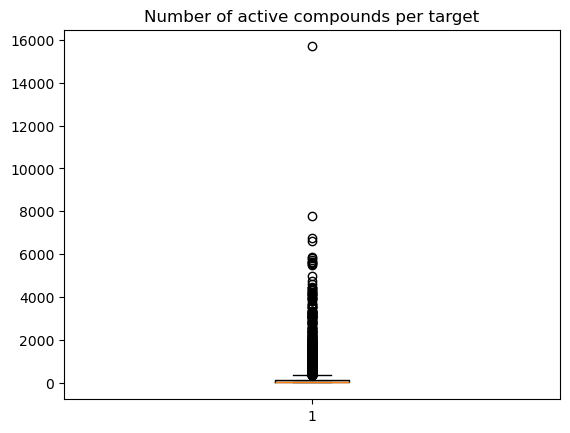

In [2]:
# 5. Data Exploration
# plot nº of active compounds per target
plt.boxplot(np.sum(s0_V_filtered, axis=0))
plt.title("Number of active compounds per target")
plt.savefig("../output/figures/n_actives_per_target.png", dpi=300)

In [ ]:
# 5. Data Exploration
# plot nº of active compounds per target
plt.boxplot(np.sum(s0_V_filtered, axis=0))
plt.title("Number of active compounds per target")

Text(0.5, 1.0, 'Number of active compounds per target - removed 1% largest')

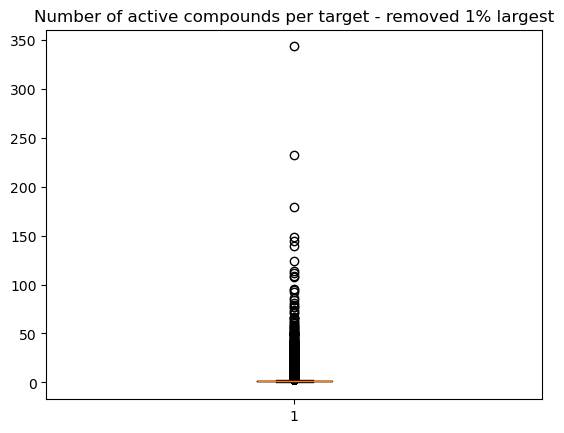

In [3]:
# plot nº of active targets per compounds
plt.boxplot(np.sum(s0_V_filtered, axis=1))
plt.title("Number of active compounds per target - removed 1% largest")

In [23]:
import pickle


indexes_percentile_path = os.path.join("..", "data", "B4.001")

n_actives_per_target = np.sum(s0_V_filtered, axis=0)
threshold = np.percentile(n_actives_per_target, 99)
top_1_pecent_targets = np.where(n_actives_per_target > threshold)[0]
bottom_99_percent_targets = np.where(n_actives_per_target <= threshold)[0]

logging.info(f"Nº of targets in the top 1%: {len(top_1_pecent_targets)}")
logging.info(f"Nº of targets in the bottom 99%: {len(bottom_99_percent_targets)}")

# save theses idxs to pickle
with open(
    os.path.join(indexes_percentile_path, "top_1_percent_targets.pkl"), "wb"
) as f:
    pickle.dump(top_1_pecent_targets, f)

with open(
    os.path.join(indexes_percentile_path, "bottom_99_percent_targets.pkl"), "wb"
) as f:
    pickle.dump(bottom_99_percent_targets, f)


# check and open
with open(
    os.path.join(indexes_percentile_path, "top_1_percent_targets.pkl"), "rb"
) as f:
    top_1_pecent_targets = pickle.load(f)

with open(
    os.path.join(indexes_percentile_path, "bottom_99_percent_targets.pkl"), "rb"
) as f:
    bottom_99_percent_targets = pickle.load(f)

logging.info(f"Nº of targets in the top 1%: {len(top_1_pecent_targets)}")
logging.info(f"Nº of targets in the bottom 99%: {len(bottom_99_percent_targets)}")

2024-05-27 22:28:54,789 - Nº of targets in the top 1%: 39
2024-05-27 22:28:54,789 - Nº of targets in the bottom 99%: 3813
2024-05-27 22:28:54,795 - Nº of targets in the top 1%: 39
2024-05-27 22:28:54,796 - Nº of targets in the bottom 99%: 3813


In [5]:
n_actives_per_target = np.sum(s0_V_filtered, axis=0)

logging.info(
    "Target with the most actives: %d - %s"
    % (
        np.argmax(n_actives_per_target),
        s0_features_filtered[np.argmax(n_actives_per_target)],
    )
)

2024-05-27 21:12:54,779 - Target with the most actives: 959 - b'P10636'


## Generating positive and negative classes

In [6]:
"""Generating Positive & Negative Classes

The objective of this script is to generate positive and negative classes and store these classes in files.
This will allow for memory efficient loading of data during training and testing.

For each positive sample we will generate 10 fold negative samples. This will allow for a balanced dataset.

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Generate Positive & Negative Classes
    4. Save Classes
"""

# 1. Imports, Variables, Functions
# imports
import pickle
from tqdm import tqdm

# variables
compounds_file_path = os.path.join("..", "data", "target_compounds")


# functions


def subsample_positives(matrix, column_index, random_seed=10):
    """
    Retrieve the indexes for rows which are positive (1) and negative (0)
    in a given column, and perform a random subsampling 10x n of positives (1).

    Arguments:
        - matrix (np.ndarray): input 2D array
        - column_index (int): index of the column to check for positives/negatives
        - random_seed (int): seed for the random number generator (optional)

    Returns:
        - positive_indexes (np.ndarray): indexes of positive rows
        - subsampled_indexes (np.ndarray): indexes of randomly subsampled rows
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    # Retrieve the indexes of positive and negative rows
    positive_indexes = np.where(matrix[:, column_index] == 1)[0]
    negative_indexes = np.where(matrix[:, column_index] == 0)[0]

    # Perform random subsampling 10x n of positives (1)
    n_positive = len(positive_indexes)
    subsample_size = min(len(negative_indexes), 10 * n_positive)

    subsampled_indexes = np.random.choice(
        negative_indexes, size=subsample_size, replace=False
    )

    # sort subsampled indexes
    # important for loading h5py files
    subsampled_indexes.sort()

    return positive_indexes, subsampled_indexes


# 2. Load Data
ratio = list()
n_data = list()


# test
n_failed_unimol = list()
if os.path.exists(compounds_file_path):
    for column_idx in tqdm(range(s0_V_filtered.shape[1])):
        with open(
            os.path.join(compounds_file_path, f"target_{column_idx}.pkl"), "rb"
        ) as f:
            d_classes = pickle.load(f)
            ratio.append(
                len(d_classes["positive_idxs"]) / len(d_classes["negative_idxs"])
            )
            n_data.append(
                len(d_classes["positive_idxs"]) + len(d_classes["negative_idxs"])
            )

            found_ik_p = s0_iks[d_classes["positive_idxs"]]
            found_ik_n = s0_iks[d_classes["negative_idxs"]]
            set_found = set(found_ik_p).union(set(found_ik_n))

            if len(set_found.intersection(iks_failed_unimol)) > 0:
                n_failed_unimol.append(
                    (column_idx, len(set_found.intersection(iks_failed_unimol)))
                )

else:
    os.mkdir(compounds_file_path)
    # 3. Generate Positive & Negative Classes
    for column_idx in tqdm(range(s0_V_filtered.shape[1])):

        # generate positive and negative classes
        positive_indexes, subsampled_indexes = subsample_positives(
            s0_V_filtered, column_idx, random_seed=10
        )

        # target name
        target_name = s0_features_masked[column_idx]

        # save to dictionary
        d_classes = {
            "positive_idxs": positive_indexes,
            "negative_idxs": subsampled_indexes,
            "positive_iks": s0_iks[positive_indexes],
            "negative_iks": s0_iks[subsampled_indexes],
            "metadata": s0_features_masked,
        }

        ratio.append(len(positive_indexes) / len(subsampled_indexes))
        n_data.append(len(positive_indexes) + len(subsampled_indexes))
        # 4. Save Classes
        # save to pickle file
        with open(
            os.path.join(compounds_file_path, f"target_{column_idx}.pkl"), "wb"
        ) as f:
            pickle.dump(d_classes, f)

100%|██████████| 3852/3852 [00:47<00:00, 81.83it/s] 


In [9]:
logging.info(f"Nº of failed {len([x for x in n_failed_unimol if x[1]>0])}")

2024-05-27 21:17:04,283 - Nº of failed 0


Text(0.5, 1.0, 'Positive to Negative Ratio')

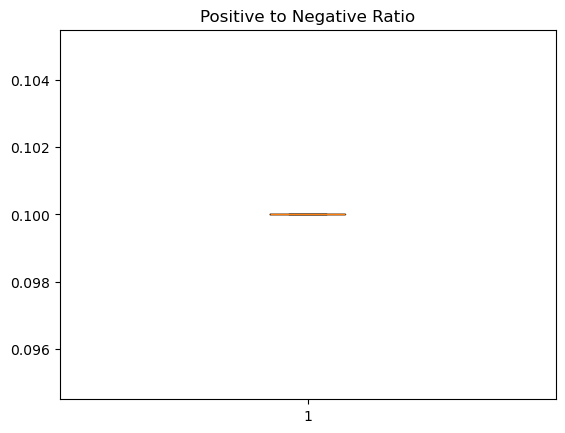

In [10]:
plt.boxplot(ratio)
plt.title("Positive to Negative Ratio")

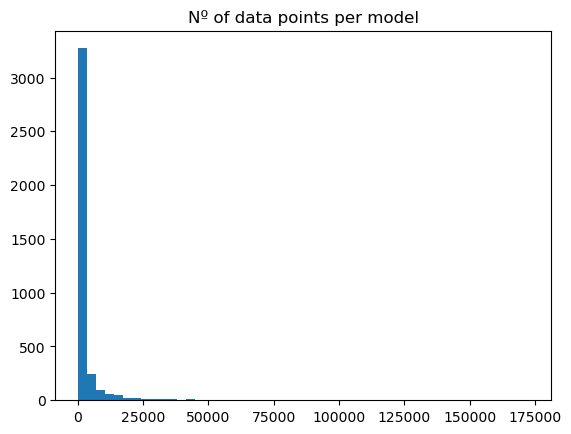

In [11]:
plt.hist(n_data, bins=50)
plt.title("Nº of data points per model")
plt.savefig("../output/figures/n_data_points.model.png", dpi=300)

In [12]:
# check that all the positives and negatives are correct

# open data matrix
with h5py.File(data_output_path, "r") as f:
    s0_V_check = f["V"][:]


# check that all the positives and negatives are correct
for column_idx in range(s0_V_check.shape[1]):
    with open(os.path.join(compounds_file_path, f"target_{column_idx}.pkl"), "rb") as f:
        d_classes = pickle.load(f)

    assert np.all(s0_V_check[d_classes["positive_idxs"], column_idx] == 1)
    assert np.all(s0_V_check[d_classes["negative_idxs"], column_idx] == 0)

## Generating Molecular Descriptors

### Loading new Signaturizer Descriptors

In [35]:
"""Generating new Signaturizer Descriptors

    Structure:
        1. Imports, Variables, Functions
        2. Load Data
        3. Signaturizer
        4. Save Data
"""

# 1. Imports, Variables, Functions
# imports
from signaturizer3d import Signaturizer, CCSpace
import numpy as np
import os, sys, h5py, logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")
# variables
output_new_signaturizer_path = os.path.join(
    "..", "data", "features", "b4.signaturizer3d.h5"
)
s0_filtered_data_path = os.path.join("..", "data", "B4.001", "s0_filtered.h5")


# functions


# 2. Load Data
if os.path.exists(output_new_signaturizer_path):
    logging.info("Data already exists")
    with h5py.File(output_new_signaturizer_path, "r") as f:
        results = f["V"][:]
        s0_smiles = f["smiles"][:]
        s0_iks_masked = f["inchikeys"][:]

else:
    # load data from the saved file
    with h5py.File(s0_filtered_data_path, "r") as f:
        s0_V_filtered = f["V"][:]
        s0_features_filtered = f["features"][:].astype(str)
        s0_smiles = f["smiles"][:].astype(str)
        s0_iks_masked = f["inchikeys"][:].astype(str)

    logging.info(
        f"Data loaded V: {s0_V_filtered.shape}, features: {s0_features_filtered.shape}, smiles: {len(s0_smiles)}, inchikeys: {len(s0_iks_masked)}"
    )

    # 3. Signaturizer
    # load the predictor for B4

    CCSpace.print_spaces()  # Prints a description of the 25 available spaces

    signaturizer = Signaturizer(CCSpace.B4)

    # run prediction
    results = signaturizer.infer_from_smiles(s0_smiles)
    print(results.signature)
    logging.info(f"Results shape {results.signature.shape}")

    # 4. Save Data
    s0_smiles = np.array(s0_smiles, dtype="S")
    s0_iks_masked = np.array(s0_iks_masked, dtype="S")

    # 4. Save Data
    with h5py.File(output_new_signaturizer_path, "w") as f:
        f.create_dataset("V", data=results)
        f.create_dataset("smiles", data=s0_smiles)
        f.create_dataset("inchikeys", data=s0_iks_masked)

ModuleNotFoundError: No module named 'signaturizer3d'

### Loading old signaturizer

In [16]:
"""Generating old Signaturizer Descriptors

    Structure:
        1. Imports, Variables, Functions
        2. Load Data
        3. Signaturizer
        4. Save Data
"""

# 1. Imports, Variables, Functions
# imports

# variables
output_old_signaturizer_path = os.path.join(
    "..", "data", "features", "old_signaturizer.b4.h5"
)


# functions
from signaturizer import Signaturizer


# 2. Load Data
# load data from the saved file
with h5py.File(data_output_path, "r") as f:
    s0_V_filtered = f["V"][:]
    s0_features_filtered = f["features"][:].astype(str)
    s0_smiles = f["smiles"][:].astype(str)
    s0_iks_masked = f["inchikeys"][:].astype(str)

logging.info(
    f"Data loaded V: {s0_V_filtered.shape}, features: {s0_features_filtered.shape}, smiles: {len(s0_smiles)}, inchikeys: {len(s0_iks_masked)}"
)

# 3. Signaturizer
# load the predictor for B4

sign = Signaturizer("B4")

# run prediction
results = sign.predict(s0_smiles)
print(results.signature)
logging.info(f"Results shape {results.signature.shape}")


# 4. Save Data
with h5py.File(output_old_signaturizer_path, "w") as f:
    f.create_dataset("V", data=results.signature)
    f.create_dataset("features", data=results.features)
    f.create_dataset("smiles", data=results.smiles)
    f.create_dataset("inchikeys", data=s0_iks_masked)

2024-05-27 21:23:47,064 - Nº of failed: 0
2024-05-27 21:23:47,765 - Nº of failed: 0
2024-05-27 21:23:48,483 - Nº of failed: 0
2024-05-27 21:23:49,252 - Nº of failed: 0
2024-05-27 21:23:49,987 - Nº of failed: 0
2024-05-27 21:23:50,819 - Nº of failed: 0
2024-05-27 21:23:51,593 - Nº of failed: 0
2024-05-27 21:23:52,427 - Nº of failed: 0
2024-05-27 21:23:53,204 - Nº of failed: 0
2024-05-27 21:23:54,039 - Nº of failed: 0
2024-05-27 21:23:54,075 - Number of keys: 992059
2024-05-27 21:23:54,827 - Nº of failed: 0
2024-05-27 21:23:55,790 - Nº of failed: 0
2024-05-27 21:23:56,585 - Nº of failed: 0
2024-05-27 21:23:57,307 - Nº of failed: 0
2024-05-27 21:23:58,056 - Nº of failed: 0
2024-05-27 21:23:58,776 - Nº of failed: 0
2024-05-27 21:23:59,547 - Nº of failed: 0
2024-05-27 21:24:00,322 - Nº of failed: 0
2024-05-27 21:24:01,117 - Nº of failed: 0
2024-05-27 21:24:01,807 - Nº of failed: 0
2024-05-27 21:24:01,841 - Number of keys: 992059
2024-05-27 21:24:28,851 - Data loaded V: (616407, 3852), featu

### Generating Morgan Fingerprint Descriptors

In [3]:
"""Generating Morgan Fingerprint Descriptors

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Compute Morgan Fingerprints
    4. Save Data

"""

# 1. Imports, Variables, Functions
# imports
import numpy as np, h5py, os, sys, pandas as pd
import h5py
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")

# variables
s0_filtered_path = os.path.join("..", "data", "B4.001", "s0_filtered.h5")
output_ecfp4_path = os.path.join("..", "data", "features", "ecfp4.h5")
output_ecfp4_useChirality_path = os.path.join(
    "..", "data", "features", "ecfp4.useChirality.h5"
)


# functions
def generate_morgan_fingerprints(smiles_list, radius=2, n_bits=2048, use_chiral=False):
    """Generate Morgan Fingerprints
    Arguments:
        - smiles_.ist (list): list of SMILES strings
        - radius (int): radius of the fingerprint
        - n_bits (int): number of bits in the fingerprint
    Returns:
        - fingerprints (list): list of fingerprints
    """
    fingerprints = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fingerprint = AllChem.GetMorganFingerprintAsBitVect(
                mol, radius, nBits=n_bits, useChirality=use_chiral
            )
            fingerprints.append(fingerprint)
        else:
            fingerprints.append(None)  # Handle invalid SMILES strings
    return fingerprints


# 2. Load Data
if os.path.exists(output_ecfp4_path) and os.path.exists(output_ecfp4_useChirality_path):
    logging.info("Data already exists")

    with h5py.File(output_ecfp4_path, "r") as f:
        fingerprints_matrix = f["V"][:]
        s0_smiles = f["smiles"][:].astype(str)
        s0_iks = f["inchikeys"][:].astype(str)

    logging.info(
        f"Fingerprint data shape {fingerprints_matrix.shape}, nº of smiles {len(s0_smiles)}, nº of inchikeys {len(s0_iks)}"
    )

    with h5py.File(output_ecfp4_useChirality_path, "r") as f:
        fingerprints_matrix_chiral = f["V"][:]
        s0_smiles = f["smiles"][:].astype(str)
        s0_iks = f["inchikeys"][:].astype(str)

    logging.info(
        f"Fingerprint data shape {fingerprints_matrix_chiral.shape}, nº of smiles {len(s0_smiles)}, nº of inchikeys {len(s0_iks)}"
    )

else:
    with h5py.File(s0_filtered_path, "r") as f:
        # s0_V = f["V"][:]
        # s0_features = f["features"][:].astype(str)
        s0_smiles = f["smiles"][:].astype(str)
        s0_iks = f["inchikeys"][:].astype(str)

    # 3. Compute Morgan Fingerprints
    # ECFP4
    fingerprints = generate_morgan_fingerprints(s0_smiles)
    fingerprints_matrix = np.array(fingerprints)

    # ECFP4 useChirality = True
    fingerprint_chiral = generate_morgan_fingerprints(s0_smiles, use_chiral=True)
    fingerprints_matrix_chiral = np.array(fingerprint_chiral)

    # 4. Save Data
    s0_smiles = np.array(s0_smiles, dtype="S")
    s0_iks = np.array(s0_iks, dtype="S")

    with h5py.File(output_ecfp4_path, "w") as f:
        f.create_dataset("V", data=fingerprints_matrix)
        f.create_dataset("smiles", data=s0_smiles)
        f.create_dataset("inchikeys", data=s0_iks)

    with h5py.File(output_ecfp4_useChirality_path, "w") as f:
        f.create_dataset("V", data=fingerprints_matrix_chiral)
        f.create_dataset("smiles", data=s0_smiles)
        f.create_dataset("inchikeys", data=s0_iks)

### Generating MAPC descriptors

In [1]:
"""Generating MAPC descriptors

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Compute MAPC Descriptors
    4. Save Data
"""

# 1. Imports, Variables, Functions
# imports
from rdkit import Chem
import sys, os, h5py
from mapchiral.mapchiral import encode, jaccard_similarity
import logging
import numpy as np
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")

# variables
s0_filtered_path = os.path.join("..", "data", "B4.001", "s0_filtered.h5")
output_mapc_path = os.path.join("..", "data", "features", "mapc.h5")


# functions
def compute_mapc_fingerprint(smiles):
    """Compute MAPC Fingerprint
    Arguments:
        - smiles (str): SMILES string
    Returns:
        - fingerprint (np.ndarray): MAPC fingerprint
    """
    molecule = Chem.MolFromSmiles(smiles)
    if molecule:
        try:
            return encode(molecule, max_radius=2, n_permutations=2048, mapping=False)
        except RuntimeError as e:
            logging.warning(f"Error processing molecule {smiles}: {e}")
            return None
    else:
        return None


# 2. Load Data
if os.path.exists(output_mapc_path):
    logging.info("Data already exists")
    with h5py.File(output_mapc_path, "r") as f:
        mapc_matrix = f["V"][:]
        s0_smiles = f["smiles"][:].astype(str)
        s0_iks = f["inchikeys"][:].astype(str)

    logging.info(
        f"MAPC matrix shape {mapc_matrix.shape}, nº of smiles {len(s0_smiles)}, nº of inchikeys {len(s0_iks)}"
    )

else:

    with h5py.File(s0_filtered_path, "r") as f:
        # s0_V = f["V"][:]
        # s0_features = f["features"][:].astype(str)
        s0_smiles = f["smiles"][:].astype(str)
        s0_iks = f["inchikeys"][:].astype(str)

    # 3. Compute MAPC Descriptors
    # Parallelize computation of fingerprints using process_map
    mpac_descriptors = process_map(
        compute_mapc_fingerprint,
        s0_smiles,
        max_workers=200,
        chunksize=1000,
    )  # Adjust max_workers as needed

    mapc_matrix = np.array(mpac_descriptors)

    # 4. Save Data
    s0_smiles = np.array(s0_smiles, dtype="S")
    s0_iks = np.array(s0_iks, dtype="S")

    with h5py.File(output_mapc_path, "w") as f:
        f.create_dataset("V", data=mapc_matrix)
        f.create_dataset("smiles", data=s0_smiles)
        f.create_dataset("inchikeys", data=s0_iks)

/home/ddalton/miniconda3/envs/mapchiral/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 618442/618442 [06:55<00:00, 1489.62it/s]


In [7]:
s0_filtered_path = os.path.join("..", "data", "B4.001", "s0_filtered.h5")
old_output_mapc_path = os.path.join("..", "data", "old.features", "mapc.h5")
output_mapc_path = os.path.join("..", "data", "features", "mapc.h5")


with h5py.File(s0_filtered_path, "r") as f:
    # s0_V = f["V"][:]
    # s0_features = f["features"][:].astype(str)
    s0_smiles = f["smiles"][:].astype(str)
    s0_iks = f["inchikeys"][:].astype(str)


with h5py.File(old_output_mapc_path, "r") as f:
    mapc_matrix_old = f["V"][:]
    s0_smiles_old = f["smiles"][:].astype(str)
    s0_iks_old = f["inchikeys"][:].astype(str)

ik_2_mapc = dict(zip(s0_iks_old, mapc_matrix_old))

mapc_matrix = np.array([ik_2_mapc[ik] for ik in s0_iks])

s0_smiles = np.array(s0_smiles, dtype="S")
s0_iks = np.array(s0_iks, dtype="S")

logging.info(
    f"MAPC matrix shape {mapc_matrix.shape}, nº of smiles {len(s0_smiles)}, nº of inchikeys {len(s0_iks)}"
)

with h5py.File(output_mapc_path, "w") as f:
    f.create_dataset("V", data=mapc_matrix)
    f.create_dataset("smiles", data=s0_smiles)
    f.create_dataset("inchikeys", data=s0_iks)

2024-05-27 22:00:30,585 - MAPC matrix shape (616407, 2048), nº of smiles 616407, nº of inchikeys 616407


In [3]:
failed = [False if m is not None else True for m in mpac_descriptors]

In [5]:
s0_iks[failed]

array(['FOLRZVDNLGHIOC-DMXXOQFQSA-L', 'ICPUWTORQSFCPE-BHVUHMJOSA-L',
       'JGQCYTLLVMXXQL-LGRLCBGBSA-N', 'KBPQVWUBVGLKRQ-LNHPXXNLSA-L',
       'RXJKYBQTPDFIPO-PWSFYNAUSA-L', 'UXJXOYOZCMIBIG-MYESYUTFSA-N',
       'WUCVZNCZYXRPHR-LTBQDQKYSA-N'], dtype='<U27')

In [9]:
s0_iks_mapc_failed = [
    "FOLRZVDNLGHIOC-DMXXOQFQSA-L",
    "ICPUWTORQSFCPE-BHVUHMJOSA-L",
    "JGQCYTLLVMXXQL-LGRLCBGBSA-N",
    "KBPQVWUBVGLKRQ-LNHPXXNLSA-L",
    "RXJKYBQTPDFIPO-PWSFYNAUSA-L",
    "UXJXOYOZCMIBIG-MYESYUTFSA-N",
    "WUCVZNCZYXRPHR-LTBQDQKYSA-N",
]

s0_smiles_mapc_failed = [
    "C[N+]1(C)C[C@@]23c4c5c6c7c8c9c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c%21c(c2c2c4c4c6c9c6c4c4c2c%21c2c%19c(c%18%14)c9c%13c%10c6c9c24)C2=C4c6c(c-%16c9c%10c6[C@H]([C@@H]5C7=C%10[C@]5(C[N+](C)(C)C[C@]8%115)[C@H]9[C@H]%15%12)[C@@]43C1)[C@@H]%17[C@H]2%20",
    "CCCCCCCCCC[N@+]1(C)C[C@@]23c4c5c6c7c8c9c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c%21c(c2c2c4c4c6c9c6c4c4c2c%21c2c%19c(c%18%14)c9c%13c%10c6c9c24)C2=C4c6c(c-%16c9c%10c6[C@H]([C@@H]5C7=C%10[C@]5(C[N+](C)(C)C[C@]8%115)[C@H]9[C@H]%15%12)[C@@]43C1)[C@@H]%17[C@H]2%20",
    "O=C(O)CN1C[C@@]23C4=C5c6c7c8c9c(c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c%21c%22c%23c(c6c6c8c8c%24c9c%11c9c(c%16%12)c%17c%11c%19c%12c%21c%23c6c8c%12c%11c9%24)[C@@H]5[C@@H]5C=%22[C@H]6c8c5c4c(c-%14c8[C@H]%15[C@@H]%18[C@@H]%206)[C@@H]2[C@H]%13%10)[C@]73[C@@H]1C(=O)O",
    "C[N+]1(C)C[C@@]23C4=C5C6=C7[C@@H]8C9=c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c%21c%22c%23c(c4c4c2c2c%24c%25c(c%10c(c%11%15)c%10c%16c%19c(c%25%10)c%10c%20c%23c4c%24%10)[C@@H]2[C@H]9[C@]73C1)[C@H]1C%22=C2c3c(c6c(c-%13c3[C@H]([C@H]%14%17)[C@@]23C[N+](C)(C)C[C@]%21%183)[C@@H]%128)[C@@H]51",
    "C[N+]1(C)C[C@]23c4c5c6c7c8c9c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c(c2c2c4c4c6c6c8c%10c8c%12c%10c%14c(c%15%19)c%12c%20c2c2c4c6c8c%10c%122)[C@@H]%18[C@H]2c4c6c8c%10c(c4-%17)[C@@H]%16[C@H]%13[C@@]%114C[N+](C)(C)C[C@]%104C=9[C@H]8[C@@H]7C5=C6[C@]23C1",
    "O=C(O)C1(C(=O)O)[C@@]23C4=c5c6c7c8c9c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c%21c%22c%23c(c5c5c6c6c8c%11c8c%11c%12c%15c%12c(c%20%16)c%21c%15c%23c5c(c68)c%15c%12%11)[C@@]12[C@@H]%22[C@H]%19c1c-%18c2c5c(c13)[C@@H]4[C@@H]7C9=C5[C@@]1([C@H]2[C@H]%17%14)C(C(=O)O)(C(=O)O)[C@]%10%131",
    "C=C(O)C[C@H]1[C@@H](C(=O)O)[C@@]23C4=C5c6c7c8c9c(c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c%21c%22c%23c(c6c6c8c8c%24c9c%11c9c(c%16%12)c%17c%11c%19c%12c%21c%23c6c8c%12c%11c9%24)[C@@H]5[C@@H]5C=%22[C@H]6c8c5c4c(c-%14c8[C@H]%15[C@@H]%18[C@@H]%206)[C@@H]2[C@H]%13%10)[C@]73[C@@H]1C(=O)O",
]

In [11]:
import pandas as pd

df_cc = pd.read_csv(
    "/aloy/home/acomajuncosa/Aksel/CC_standardisation_standardiser/CC_MOLECULES_STD.tsv",
    sep="\t",
)

In [13]:
for ik in s0_iks_mapc_failed:
    print(df_cc[df_cc["inchikey"] == ik]["smiles"].values[0])

C[N+]1(C)C[C@@]23c4c5c6c7c8c9c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c%21c(c2c2c4c4c6c9c6c4c4c2c%21c2c%19c(c%18%14)c9c%13c%10c6c9c24)C2=C4c6c(c-%16c9c%10c6[C@H]([C@@H]5C7=C%10[C@]5(C[N+](C)(C)C[C@]8%115)[C@H]9[C@H]%15%12)[C@@]43C1)[C@@H]%17[C@H]2%20
CCCCCCCCCC[N@+]1(C)C[C@@]23c4c5c6c7c8c9c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c%21c(c2c2c4c4c6c9c6c4c4c2c%21c2c%19c(c%18%14)c9c%13c%10c6c9c24)C2=C4c6c(c-%16c9c%10c6[C@H]([C@@H]5C7=C%10[C@]5(C[N+](C)(C)C[C@]8%115)[C@H]9[C@H]%15%12)[C@@]43C1)[C@@H]%17[C@H]2%20
O=C(O)CN1C[C@@]23C4=C5c6c7c8c9c(c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c%21c%22c%23c(c6c6c8c8c%24c9c%11c9c(c%16%12)c%17c%11c%19c%12c%21c%23c6c8c%12c%11c9%24)[C@@H]5[C@@H]5C=%22[C@H]6c8c5c4c(c-%14c8[C@H]%15[C@@H]%18[C@@H]%206)[C@@H]2[C@H]%13%10)[C@]73[C@@H]1C(=O)O
C[N+]1(C)C[C@@]23C4=C5C6=C7[C@@H]8C9=c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c%21c%22c%23c(c4c4c2c2c%24c%25c(c%10c(c%11%15)c%10c%16c%19c(c%25%10)c%10c%20c%23c4c%24%10)[C@@H]2[C@H]9[C@]73C1)[C@H]1C%22=C2c3c(c6c

### Generating UNIMOL Descriptors

In [1]:
"""Generating UNIMOL Descriptors

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Compute UNIMOL Descriptors
    4. Save Data
"""

# 1. Imports, Variables, Functions
# imports
# from rdkit import Chem
import sys, os, h5py
import logging
import numpy as np
from unimol_tools import UniMolRepr
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")

# variables
s0_filtered_path = os.path.join("..", "data", "B4.001", "s0_filtered.h5")
output_unimol_path = os.path.join("..", "data", "features", "unimol.h5")

# functions
with h5py.File(s0_filtered_path, "r") as f:
    # s0_V = f["V"][:]
    # s0_features = f["features"][:].astype(str)
    s0_smiles = f["smiles"][:].astype(str)
    s0_iks = f["inchikeys"][:].astype(str)

# 2. Load Data


# 3. Compute UNIMOL Descriptors
clf = UniMolRepr(data_type="molecule", remove_hs=False)

fused_multi_tensor is not installed corrected
fused_rounding is not installed corrected
fused_layer_norm is not installed corrected
fused_softmax is not installed corrected


2024-05-28 18:29:22 | unimol_tools/models/unimol.py | 146 | INFO | Uni-Mol(QSAR) | Loading pretrained weights from /home/ddalton/miniconda3/envs/UniCore-env/lib/python3.10/site-packages/unimol_tools-1.0.0-py3.10.egg/unimol_tools/weights/mol_pre_all_h_220816.pt
2024-05-28 18:29:22,565 - Loading pretrained weights from /home/ddalton/miniconda3/envs/UniCore-env/lib/python3.10/site-packages/unimol_tools-1.0.0-py3.10.egg/unimol_tools/weights/mol_pre_all_h_220816.pt


In [12]:
unimol_repr = clf.get_repr(list(s0_smiles), return_atomic_reprs=True)

# CLS token repr
print(np.array(unimol_repr["cls_repr"]).shape)

unimol_embeddings = np.array(unimol_repr["cls_repr"])

# 4. Save Data
# save
s0_smiles = np.array(s0_smiles, dtype="S")
s0_iks = np.array(s0_iks, dtype="S")

# 4. Save Data
output_unimol_path = os.path.join("..", "data", "features", "unimol.h5")

with h5py.File(output_unimol_path, "w") as f:
    f.create_dataset("V", data=unimol_embeddings)
    f.create_dataset("smiles", data=s0_smiles)
    f.create_dataset("inchikeys", data=s0_iks)

2024-05-27 17:06:03 | unimol_tools/data/conformer.py | 90 | INFO | Uni-Mol(QSAR) | Start generating conformers...
2024-05-27 17:06:03,398 - Start generating conformers...
618442it [1:55:58, 88.88it/s] 
2024-05-27 19:02:02 | unimol_tools/data/conformer.py | 94 | INFO | Uni-Mol(QSAR) | Failed to generate conformers for 0.00% of molecules.
2024-05-27 19:02:02,847 - Failed to generate conformers for 0.00% of molecules.
2024-05-27 19:02:04 | unimol_tools/data/conformer.py | 96 | INFO | Uni-Mol(QSAR) | Failed to generate 3d conformers for 0.52% of molecules.
2024-05-27 19:02:04,270 - Failed to generate 3d conformers for 0.52% of molecules.
  2%|▏         | 451/19327 [14:53<10:23:34,  1.98s/it]


KeyboardInterrupt: 

## Loading Classes & Descriptors

## Test Run Model

In [16]:
"""Test Run Model

The objective of this script is to train a model on a single target.

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Define Cross Validation
    4. Define Model
    5. Train Model
    6. Evaluate Model
    7. Store Results
"""

# 1. Imports, Variables, Functions
# imports
import sklearn
import h5py, numpy as np, os, pickle
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    matthews_corrcoef,
    balanced_accuracy_score,
)
from tqdm import tqdm
import logging
from sklearn.metrics import average_precision_score

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")

# variables
feature_variable = "mapc"
feature_variables = [
    "a1.signaturizer",
    "b4.signaturizer",
    "b4.signaturizer3d",
    "ecfp4.useChirality",
    "ecfp4",
    "mapc",
]

assert feature_variable in feature_variables, "ERR - Feature variable not found"

iteration = 1009
target = "bottom"

assert target in ["top", "bottom"], "ERR - Target not found"

features_file_path = os.path.join("..", "data", "features", f"{feature_variable}.h5")
compounds_file_path = os.path.join("..", "data", "target_compounds")

results_path = os.path.join("..", "output", "results", feature_variable)


if not os.path.exists(results_path):
    os.mkdir(results_path)

# functions


# 2. Load Data
# load list of indexes
if target == "top":
    with open(
        os.path.join("..", "data", "B4.001", "top_1_percent_targets.pkl"), "rb"
    ) as f:
        target_idxs = pickle.load(f)
    target_idx = target_idxs[iteration]

elif target == "bottom":
    with open(
        os.path.join("..", "data", "B4.001", "bottom_99_percent_targets.pkl"), "rb"
    ) as f:
        target_idxs = pickle.load(f)
    target_idx = target_idxs[iteration]

logging.info(f"Target index: {target_idx}")

# load classes
logging.info(f"Loading data from {compounds_file_path}")

with open(os.path.join(compounds_file_path, f"target_{target_idx}.pkl"), "rb") as f:
    d_classes = pickle.load(f)

positive_idxs = d_classes["positive_idxs"]
negative_idxs = d_classes["negative_idxs"]

positive_iks = d_classes["positive_iks"]
negative_iks = d_classes["negative_iks"]

logging.info(
    f"Positive samples: {len(positive_idxs)}, Negative samples: {len(negative_idxs)}"
)

# load features
logging.info(f"Loading features from {features_file_path}")

with h5py.File(features_file_path, "r") as f:
    positive_V = f["V"][positive_idxs]
    negative_V = f["V"][negative_idxs]
    positive_iks_loaded = f["inchikeys"][positive_idxs].astype("<U")
    negative_iks_loaded = f["inchikeys"][negative_idxs].astype("<U")

logging.info(f"Loaded features shape: {positive_V.shape}, {negative_V.shape}")

# check if iks match
assert (positive_iks_loaded == positive_iks).all, "ERR iks do not match"
assert (negative_iks_loaded == negative_iks).all, "ERR iks do not match"


# define data and labels
X_data = np.concatenate([positive_V, negative_V], axis=0)
y_data = np.concatenate([np.ones(len(positive_V)), np.zeros(len(negative_V))], axis=0)

logging.info(
    f"Merged positive & negative class data successfully: {X_data.shape}, {y_data.shape}"
)

logging.info(f"Size X of data {sys.getsizeof(X_data) / 1e6} MB")

# 3. Define Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Train and Evaluate Model
results = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1_score": [],
    "confusion_matrix": [],
    "roc_auc": [],
    "auprc": [],
    "mcc": [],
    "balanced_accuracy": [],
    "random_auprc": [],
    "target_idx": [],
    "n_positives_test": [],
    "n_positives_total": [],
}

fold = 0

# 5. Define Model
# A parameter grid for XGBoost
"""Parameter Explanation:
- min_child_weight: Higher values prevent model from learning highly specific patterns.
- gamma: Regularization parameter. The higher the value, the more regularization, leading to less overfitting.
- colsample_bytree: Fraction of features to be randomly sampled for each tree.
- max_depth: Maximum depth of the tree.
"""

# params = {
#     "min_child_weight": [1, 5, 10],
#     "gamma": [0.5, 1, 1.5, 2, 5],
#     "subsample": [0.6, 0.8, 1.0],
#     "colsample_bytree": [0.6, 0.8, 1.0],
#     "max_depth": [3, 4, 5],
# }


for train_index, test_index in tqdm(skf.split(X_data, y_data)):
    X_train, X_test = X_data[train_index], X_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    # Check for positive class in both train and test sets
    assert np.any(y_train == 1), "Train fold does not have any positive samples"
    assert np.any(y_test == 1), "Test fold does not have any positive samples"

    # Train the model
    model = XGBClassifier()
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    auprc = average_precision_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    # Append metrics to results dictionary
    results["accuracy"].append(accuracy)
    results["precision"].append(precision)
    results["recall"].append(recall)
    results["f1_score"].append(f1)
    results["confusion_matrix"].append(conf_matrix)
    results["roc_auc"].append(roc_auc)
    results["auprc"].append(auprc)
    results["mcc"].append(mcc)
    results["balanced_accuracy"].append(balanced_acc)
    results["random_auprc"].append(np.sum(y_test) / len(y_test))
    results["n_positives_test"].append(np.sum(y_test))
    results["n_positives_total"].append(np.sum(y_data))
    results["target_idx"].append(target_idx)

    fold += 1
    logging.info(f"Nº of positive samples in test: {np.sum(y_test)}")
    logging.info(
        f"Fold {fold} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}"
    )

# 6. Store Results
results_df = pd.DataFrame(results)
results_df.to_csv(
    os.path.join(results_path, f"results.target_idx_{target_idx}.csv"), index=False
)

2024-05-27 22:18:08,192 - Target index: 1021
2024-05-27 22:18:08,193 - Loading data from ../data/target_compounds
2024-05-27 22:18:08,211 - Positive samples: 14, Negative samples: 140
2024-05-27 22:18:08,211 - Loading features from ../data/features/mapc.h5
2024-05-27 22:18:12,669 - Loaded features shape: (14, 2048), (140, 2048)
2024-05-27 22:18:12,670 - Merged positive & negative class data successfully: (154, 2048), (154,)
2024-05-27 22:18:12,670 - Size X of data 1.261696 MB
0it [00:00, ?it/s]2024-05-27 22:18:12,819 - Nº of positive samples in test: 3.0
2024-05-27 22:18:12,819 - Fold 1 - Accuracy: 0.9355, Precision: 1.0000, Recall: 0.3333, F1 Score: 0.5000
1it [00:00,  6.75it/s]/home/ddalton/miniconda3/envs/xgboost-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len